In [1]:
import pathlib
import numpy as np
import scipy.sparse
import scipy.io
import os
import sys
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
# import utils.preprocess
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as sklearn_stopwords
from nltk import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from collections import Counter
nltk.download('wordnet')
nltk.download('stopwords')

/home/radin/anaconda3/envs/gle/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
[nltk_data] Downloading package wordnet to /home/radin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/radin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
dataset = pickle.load(open('raw/DBLP/dblp_preprocessed_dataset.pkl', 'rb'))
train_test_idx = pickle.load(open('raw/DBLP/Train_Test_indices.pkl', 'rb'))
docID_venue = pickle.load(open('raw/DBLP/documentID_venue.pkl', 'rb'))

In [3]:
author_label = pd.DataFrame(columns=['author_id', 'label', 'author_name', 'features'])
paper_author = pd.DataFrame(columns=['paper_id', 'author_id'])
paper_conf = pd.DataFrame(columns=['paper_id', 'conf_id'])
paper_term = pd.DataFrame(columns=['paper_id', 'term_id'])
papers = pd.DataFrame(columns=['paper_id', 'paper_title', 'features'])
terms = pd.DataFrame(columns=['term_id', 'term', 'features'])
confs = pd.DataFrame(columns=['conf_id', 'conf', 'features'])

In [4]:
# Cleaning venue names
publication_list = ['sigmod', 'vldb', 'icde', 'icdt', 'edbt', 'pods', 'kdd', 'www',
                      'sdm', 'pkdd', 'icdm', 'cikm', 'aaai', 'icml', 'ecml', 'colt',
                      'uai', 'soda', 'focs', 'stoc', 'stacs']


for i, record in enumerate(docID_venue):
    venue = record[1]
    for pub in publication_list:
        if pub in venue.lower():
            docID_venue[i][1] = pub

docID_venue_dict = {}
for record in docID_venue:
    docID_venue_dict.update({record[0]:record[1]})

In [5]:
authors_counter = Counter()
terms_counter = Counter()
authorID_feature = {}
venue_feature = {}
for record in dataset:
    paper_id = record[0]
    skillVector = record[1].todense()
    skillIdx = skillVector.nonzero()[1]
    terms_counter.update(skillIdx)
    authorIdx = record[2].todense().nonzero()[1]
    authors_counter.update(authorIdx)
    
    for authorId in authorIdx:
        paper_author = paper_author.append({'paper_id': paper_id, 'author_id': authorId}, ignore_index=True)
        
        if authorId not in authorID_feature.keys():
            authorID_feature.update({authorId: []})
        authorID_feature[authorId].append(skillVector)
    
    for skillId in skillIdx:
        paper_term = paper_term.append({'paper_id': paper_id, 'term_id': skillId}, ignore_index=True)
        
        
    papers = papers.append({'paper_id': paper_id, 'paper_title': 'na', 'features': skillVector}, ignore_index=True)
    
    target_venue = docID_venue_dict[paper_id]
    if target_venue not in venue_feature.keys():
        venue_feature.update({target_venue: []})
    venue_feature[target_venue].append(skillVector)

unique_authors_idx = list(authors_counter.keys())
for unique_authors_id in unique_authors_idx:
    if len(authorID_feature[unique_authors_id]) == 1:
        author_features = authorID_feature[unique_authors_id]
    else:
        author_features = np.sum(authorID_feature[unique_authors_id], axis=0)
    author_label = author_label.append({'author_id': unique_authors_id, 'label': -1, 'author_name': 'na', 'features': author_features}, ignore_index=True)
    
unique_terms_idx = list(terms_counter.keys())
for unique_terms_id in unique_terms_idx:
    terms = terms.append({'term_id': unique_terms_id, 'term': 'na'}, ignore_index=True)
    
conf_counter = Counter()
for record in docID_venue:
    paper_id = record[0]
    conf_counter.update([record[1]])
venues = list(conf_counter.keys())

conf_confID = {}
for i, venue in enumerate(venues):
    if len(venue_feature[venue]) == 1:
        venue_features = venueID_feature[i]
    else:
        venue_features = np.sum(venue_feature[venue], axis=0)
    confs = confs.append({'conf_id': i, 'conf': venue, 'features': venue_features}, ignore_index=True)
    conf_confID.update({venue: i})
    
for record in docID_venue:
    paper_id = record[0]
    conf_id = conf_confID[record[1]]
    paper_conf = paper_conf.append({'paper_id': paper_id, 'conf_id': conf_id}, ignore_index=True)

In [6]:
authors_counter = Counter()
terms_counter = Counter()
for record in dataset:
    paper_id = record[0]
    skillIdx = record[1].todense().nonzero()[1]
    terms_counter.update(skillIdx)
    authorIdx = record[2].todense().nonzero()[1]
    authors_counter.update(authorIdx)

In [7]:
print('Number of uniqure of authors: ', len(unique_authors_idx))

Number of uniqure of authors:  2470


In [9]:
authors = author_label['author_id'].to_list()
paper_author = paper_author[paper_author['author_id'].isin(authors)].reset_index(drop=True)
valid_papers = paper_author['paper_id'].unique()
print('Number of papers :', len(valid_papers))

papers = papers[papers['paper_id'].isin(valid_papers)].reset_index(drop=True)
paper_conf = paper_conf[paper_conf['paper_id'].isin(valid_papers)].reset_index(drop=True)
print('Number of papers :', len(paper_conf))

paper_term = paper_term[paper_term['paper_id'].isin(valid_papers)].reset_index(drop=True)
valid_terms = paper_term['term_id'].unique()
terms = terms[terms['term_id'].isin(valid_terms)].reset_index(drop=True)


author_label = author_label.sort_values('author_id').reset_index(drop=True)
papers = papers.sort_values('paper_id').reset_index(drop=True)
terms = terms.sort_values('term_id').reset_index(drop=True)
confs = confs.sort_values('conf_id').reset_index(drop=True)

print('Number of conferences ', len(confs))
print('Number of authors ', len(author_label))
print('Number of terms ', len(terms))
print('Number of papers ', len(papers))

authors_list = list(author_label['author_id'])
papers_list = list(papers['paper_id'])
term_list = list(terms['term_id'])
conf_list = list(confs['conf_id'])
dim = len(authors_list) + len(papers_list) + len(term_list) + len(confs)
print(' Total entities :: ', dim)


author_id_mapping = {row['author_id']: i for i, row in author_label.iterrows()}
paper_id_mapping = {row['paper_id']: i + len(author_label) for i, row in papers.iterrows()}
term_id_mapping = {row['term_id']: i + len(author_label) + len(papers) for i, row in terms.iterrows()}
conf_id_mapping = {row['conf_id']: i + len(author_label) + len(papers) + len(terms) for i, row in confs.iterrows()}


entity_id_map = pd.DataFrame(
    columns=['domain', 'entity_id','serial_id']
)
type_dict = { 'author': author_id_mapping, 'paper': paper_id_mapping, 'term': term_id_mapping, 'conf': conf_id_mapping }
for _type,_dict in type_dict.items():
    i = list(_dict.keys())
    j = list(_dict.values())
    _df = pd.DataFrame( data = {'entity_id': i ,'serial_id': j } )
    _df['domain'] = _type
    entity_id_map = entity_id_map.append(_df, ignore_index=True)

    
# ======================================================
# Save data
# ======================================================
data_save_path = 'processed_data/'
if not os.path.exists('processed_data'):
    os.mkdir('processed_data')
if not os.path.exists(data_save_path):
    os.mkdir(data_save_path)
entity_id_map.to_csv( os.path.join( data_save_path, 'entity_id_mapping.csv') ) 

# Create graph data
nodes_author_df = pd.DataFrame([np.asarray(row['features']).flatten() for i, row in author_label.iterrows()], index=list(author_id_mapping.values()))
nodes_paper_df = pd.DataFrame([np.asarray(row['features']).flatten() for i, row in papers.iterrows()], index=list(paper_id_mapping.values()))
nodes_term_df = pd.DataFrame({'feature1': [0]}, index=list(term_id_mapping.values()))
nodes_conf_df = pd.DataFrame([np.asarray(row['features']).flatten() for i, row in confs.iterrows()], index=list(conf_id_mapping.values()))

nodes_author_df.to_csv(os.path.join(data_save_path,'nodes_author.csv'),index = False)
nodes_paper_df.to_csv(os.path.join(data_save_path,'nodes_paper.csv'),index = False)
nodes_term_df.to_csv(os.path.join(data_save_path,'nodes_term.csv'),index = False)
nodes_conf_df.to_csv(os.path.join(data_save_path,'nodes_conf.csv'),index = False)

PA_edge_list = []
for _, row in paper_author.iterrows():
    idx1 = paper_id_mapping[row['paper_id']]
    idx2 = author_id_mapping[row['author_id']]
    PA_edge_list.append((idx1,idx2))
    
df = pd.DataFrame ( data =  np.array(PA_edge_list), columns = ['source','target'])
fpath = os.path.join(data_save_path, 'PA_edges.csv')
df.to_csv(fpath, index=False)
    
PT_edge_list = []
for _, row in paper_term.iterrows():
    idx1 = paper_id_mapping[row['paper_id']]
    idx2 = term_id_mapping[row['term_id']]
    PT_edge_list.append((idx1,idx2))

df = pd.DataFrame ( data =  np.array(PT_edge_list), columns = ['source','target'])
fpath = os.path.join(data_save_path, 'PT_edges.csv')
df.to_csv(fpath, index=False)
    

PC_edge_list = []
for _, row in paper_conf.iterrows():
    idx1 = paper_id_mapping[row['paper_id']]
    idx2 = conf_id_mapping[row['conf_id']]
    PC_edge_list.append((idx1,idx2))

df = pd.DataFrame ( data = np.array(PC_edge_list), columns = ['source','target'])
fpath = os.path.join(data_save_path, 'PC_edges.csv')
df.to_csv(fpath, index=False)

Number of papers : 33002
Number of papers : 33002
Number of conferences  21
Number of authors  2470
Number of terms  2000
Number of papers  33002
 Total entities ::  37493


In [10]:
nodes_author_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.528210,0.408854,0.0,0.0,0.324691,0.0,0.284001,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.546248,0.0,0.0
4,0.0,0.0,0.0,0.432504,0.000000,0.0,0.0,0.679256,0.0,0.000000,...,0.459837,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [11]:
nodes_paper_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
2470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
df

,source,target
0,2470,37472
1,2471,37472
2,2472,37472
3,2473,37472
4,2474,37472
...,...,...
32997,35467,37472
32998,35468,37472
32999,35469,37478
33000,35470,37478


In [16]:
entity_id_map.head(5)

,domain,entity_id,serial_id
0,author,0,0
1,author,1,1
2,author,2,2
3,author,3,3
4,author,4,4


In [17]:
entity_id_map.loc[14000]

domain         paper
entity_id    1019536
serial_id      14000
Name: 14000, dtype: object

In [18]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

In [19]:
G = StellarGraph({
    "author": nodes_author_df, 
    "paper":nodes_paper_df,
    "term": nodes_term_df,
    "conf": nodes_conf_df
},
#     edges=df, edge_type_column="rel"
    df
)

In [20]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 37493, Edges: 33002

 Node types:
  paper: [33002]
    Features: float32 vector, length 2000
    Edge types: paper-default->conf
  author: [2470]
    Features: float32 vector, length 2000
    Edge types: none
  term: [2000]
    Features: float32 vector, length 1
    Edge types: none
  conf: [21]
    Features: float32 vector, length 2000
    Edge types: conf-default->paper

 Edge types:
    conf-default->paper: [33002]
        Weights: all 1 (default)
        Features: none


In [21]:
G.node_types

{'author', 'conf', 'paper', 'term'}

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

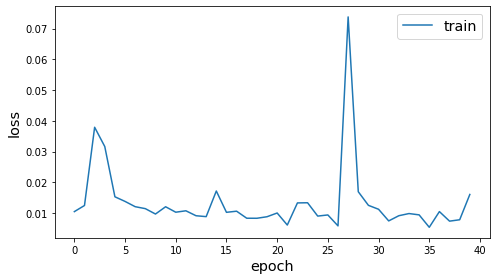

In [22]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)

def run_deep_graph_infomax(
    base_model, generator, epochs, reorder=lambda sequence, subjects: subjects
):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="paper"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
    
    all_embeddings = emb_model.predict(gen)


    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
    plot_history(history)
    
    return emb_model, x_emb_in, x_emb_out, all_embeddings

hinsage_generator = HinSAGENodeGenerator(
    G, batch_size=500, num_samples=[8], head_node_type='paper')
hinsage_model = HinSAGE(
    layer_sizes=[300], activations=["relu"], generator=hinsage_generator)
output = run_deep_graph_infomax(hinsage_model, hinsage_generator, epochs=40)

In [23]:
emb_model, x_emb_in, x_emb_out, all_embeddings = output

In [24]:
all_embeddings.shape

(33002, 300)

In [25]:
papers.head()

,paper_id,paper_title,features
0,2331,na,[[[[[0. 0. 0. ... 0. 0. 0.]]]]]
1,2332,na,[[[[[0. 0. 0. ... 0. 0. 0.]]]]]
2,2336,na,[[[[[0. 0. 0. ... 0. 0. 0.]]]]]
3,2342,na,[[[[[0. 0. 0. ... 0. 0. 0.]]]]]
4,2344,na,[[[[[0. 0. 0. ... 0. 0. 0.]]]]]


In [44]:
model_path = './embeddings'
if not os.path.exists(model_path):
    os.mkdir(model_path)
model_path = os.path.join(model_path,'DBLP')
if not os.path.exists(model_path):
    os.mkdir(model_path)

embedding_dict = {}
for i, paper_id in enumerate(paper_id_mapping.keys()):
    embedding_dict.update({paper_id: all_embeddings[i]})
pickle.dump(embedding_dict, open(model_path + '/embedding_dict.pkl', 'wb'))

In [ ]:
embedding_dict = {'user': {}, 'skill': {}}
for i, row in entity_id_mapping.iterrows():
    if row['domain'] == 'author':
        embedding_dict['user'].update({row['entity_id']: node_embeddings_normalized[row['serial_id']]})  
    elif row['domain'] == 'term':
        embedding_dict['skill'].update({row['entity_id']: node_embeddings_normalized[row['serial_id']]}) 
pickle.dump(embedding_dict, open(model_path + '/embedding_dict.pkl', 'wb'))